# Data Analysis with python II (tutorial)

## Wladimir E. Banda-Barragán

In this tutorial, we will open a VTK data file that contains data from a simulation of 2D turbulence.

To open it, as we saw in the previous lecture, we can use the VTK library.

Let us start importing some libraries:

## 1. Data import:

In [1]:
import vtk
import numpy as np
import matplotlib.pyplot as plt

We define the input directory and file name:

In [2]:
input_directory="./simulation_data/"
file_name = "turbulence_sub.vtk"

In [3]:
# Here we include some lines to select the file we want to read

reader = vtk.vtkDataSetReader()
reader.SetFileName(input_directory+file_name)

# Now, we read all the scalar and vector quantities
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

In [4]:
# Now, let's have a first look into the data
data = reader.GetOutput()

# Let's see the data structure
print(data)

vtkRectilinearGrid (0x7fa2e5b30b10)
  Debug: Off
  Modified Time: 1173
  Reference Count: 2
  Registered Events: (none)
  Information: 0x7fa2e59f07e0
  Data Released: False
  Global Release Data: Off
  UpdateTime: 1210
  Field Data:
    Debug: Off
    Modified Time: 725
    Reference Count: 1
    Registered Events: (none)
    Number Of Arrays: 0
    Number Of Components: 0
    Number Of Tuples: 0
  Number Of Points: 2601
  Number Of Cells: 2500
  Cell Data:
    Debug: Off
    Modified Time: 1171
    Reference Count: 1
    Registered Events: 
      Registered Observers:
        vtkObserver (0x7fa2e59dda70)
          Event: 33
          EventName: ModifiedEvent
          Command: 0x7fa2e5b3da90
          Priority: 0
          Tag: 1
    Number Of Arrays: 5
    Array 0 name = rho
    Array 1 name = vx1
    Array 2 name = vx2
    Array 3 name = Bx1
    Array 4 name = Bx2
    Number Of Components: 5
    Number Of Tuples: 2500
    Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
    Interpolate Flags: 

As we can see the data consists of a 2D grid of 50x50 cells/pixels, i.e. 2500 grid cells/pixels in total.

The data are organised in 5 arrays:

    Array 0 name = rho
    Array 1 name = vx1
    Array 2 name = vx2
    Array 3 name = Bx1
    Array 4 name = Bx2
    
Which we can now read with:

In [5]:
dens = data.GetCellData().GetArray("rho")
velx = data.GetCellData().GetArray("vx1")
vely = data.GetCellData().GetArray("vx2")
bfix = data.GetCellData().GetArray("Bx1")
bfiy = data.GetCellData().GetArray("Bx2")

However, after reading the data, we notice that we have 1D arrays, instead of 2D. 


In [6]:
print(np.shape(dens))

(2500,)


Therefore, we need to re-shape the array into 2D.

We can use the information on the dimensions from teh original VTK file.

In [7]:
dim = data.GetDimensions()

vec = list(dim)
vec = [i-1 for i in dim]

print("unit_vectors =", vec)

unit_vectors = [50, 50, 0]


Let's then use the above information for re-shaping the array:

In [8]:
rho = np.reshape(dens,(vec[0],vec[1]))

print(np.shape(dens), np.shape(rho))

(2500,) (50, 50)


As we can see, the original density array has been converted from 1D to 2D.

Thus, let's do the same with all the other arrays.

In [9]:
vx = np.reshape(velx,(vec[0],vec[1]))
vy = np.reshape(vely,(vec[0],vec[1]))
Bx = np.reshape(bfix,(vec[0],vec[1]))
By = np.reshape(bfiy,(vec[0],vec[1]))

print(np.max(vx))

1.8476858


### Normalisation to CGS units:

Note that this simulation is scale free, so you can change the parameters below and adapt them to different environments:

In [10]:
import math
# Density normalisation

rho_norm = 1.66e-24 #g/cm^3


# Length normalisation

L_norm = 3.086e+18 #cm = 1pc (parsec)


# Speed normalisation

v_norm = 1.e+6 #cm/s


# Then, we can estimate the B_0 to normalise the magnetic field.

B_norm = np.sqrt(4*math.pi*rho_norm*v_norm**2)

In [11]:
# Then in CGS units, we have:
rho_cgs = rho*rho_norm
vx_cgs = vx*v_norm
vy_cgs = vy*v_norm
Bx_cgs = Bx*B_norm
By_cgs = By*B_norm

print(np.max(vx_cgs))

1847685.9


## 2. Data plotting:

Now, let's take a first look at the 2D data

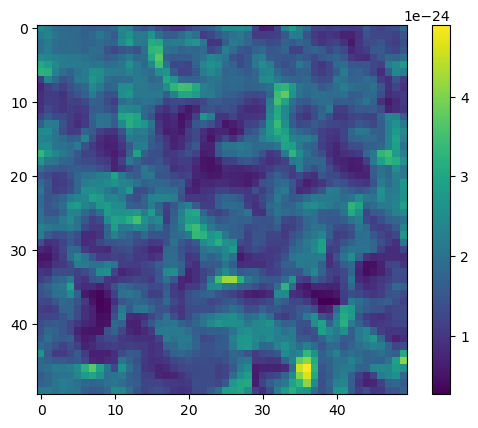

In [12]:
# Density map
plt.imshow(rho_cgs.T, interpolation='none')
plt.colorbar()
plt.show()

And for a nicer look we can you bilinear interpolation.

We can also add quiver for the velocity vectors.

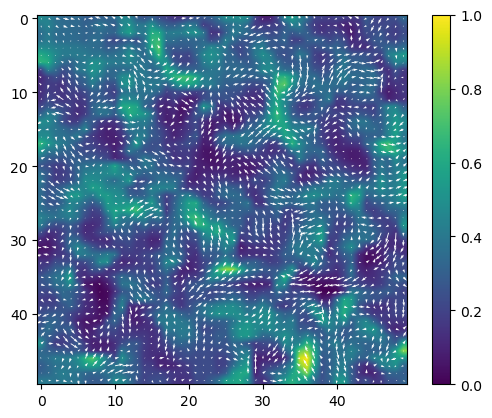

In [13]:
# Density map
plt.imshow(rho_cgs.T, interpolation='bilinear',cmap="viridis")
plt.quiver(vx_cgs,vy_cgs, color="White")
plt.colorbar()
plt.show()

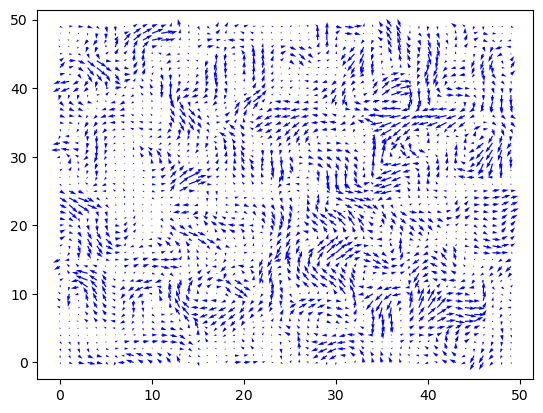

In [14]:
# Just the veclocity field
#plt.imshow(rho_cgs.T, interpolation='bilinear',cmap="viridis")
plt.quiver(vx_cgs,vy_cgs, color="Blue")
#plt.colorbar()
plt.show()

## 3. Data post-processing:




Let's now calculate and plot the flow speeds:

$$ v = \sqrt{v_x^2 + v_y^2},$$

the magnetic flux densities:

$$ B = \sqrt{B_x^2 + B_y^2}$$

and the kinetic energy density (energy per unit volume):

$$ K_e = \frac{1}{2}\rho\,v^2$$

In [15]:
# Flow speed
speed = np.sqrt(vx_cgs**2+vy_cgs**2)

# Magnetic field
bmagf = np.sqrt(Bx_cgs**2+By_cgs**2)

# Kinetic energy density
kener = 0.5*rho_cgs*speed**2


# But as we can see the above can actually be defined as a single 'magnitude' function.

def magnitude(component1, component2):
    magn = np.sqrt(component1**2+component2**2)
    return magn

# Then:

# Flow speed
speed1 = magnitude(vx_cgs,vy_cgs)

# Magnetic field
bmagf1 = magnitude(Bx_cgs,By_cgs)

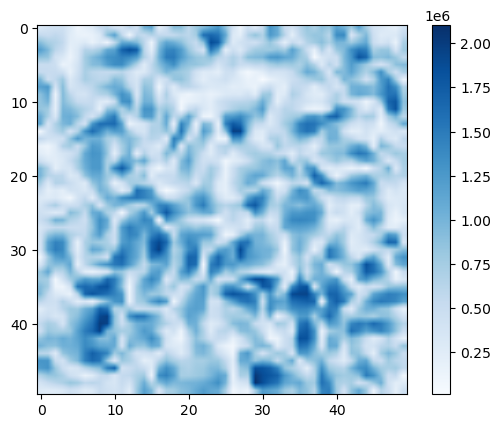

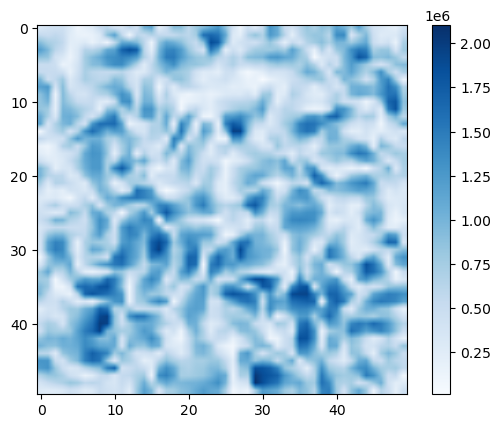

In [16]:
# Flow speed map
plt.imshow(speed.T, interpolation='bilinear', cmap='Blues')
plt.colorbar()
plt.show()

# Flow speed map
plt.imshow(speed1.T, interpolation='bilinear', cmap='Blues')
plt.colorbar()
plt.show()

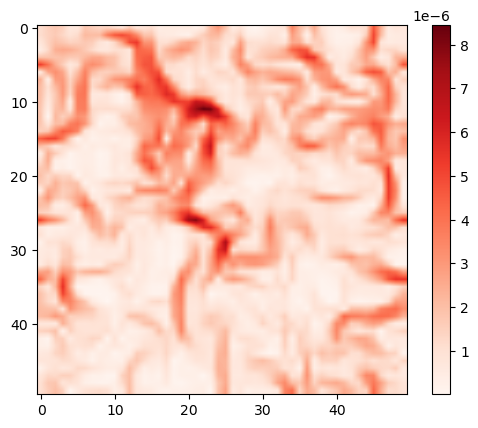

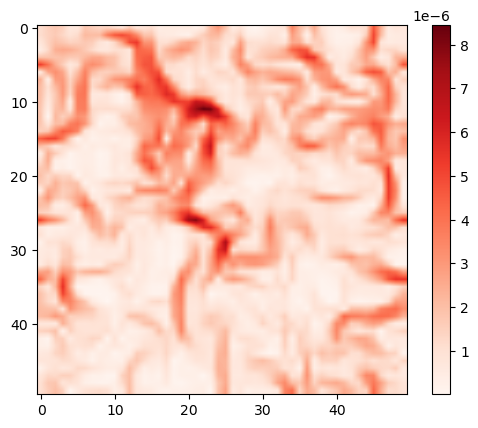

In [17]:
# Magnetic flux density map
plt.imshow(bmagf.T, interpolation='bilinear', cmap='Reds')
plt.colorbar()
plt.show()

# Magnetic flux density map
plt.imshow(bmagf1.T, interpolation='bilinear', cmap='Reds')
plt.colorbar()
plt.show()

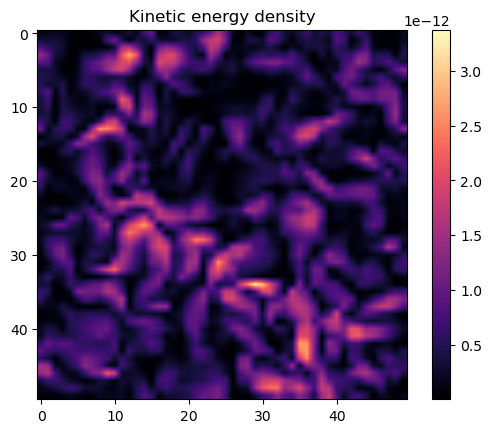

In [18]:
# Kinetic energy density
plt.imshow(kener.T, interpolation='bilinear', cmap='magma')
plt.title('Kinetic energy density')
plt.colorbar()
plt.show()

## 4. Identifying and isolating clumps in the density field.

We will find clumps manually as this is an introductory class, but there are a few tools you can use to do this in a more robust way.

Let's print the min/max and mean of the density field:

In [19]:
print(np.min(rho_cgs),np.max(rho_cgs),np.mean(rho_cgs))

2.7320526e-25 4.899519e-24 1.66e-24


Let's say we are interested in studying only gas denser than the mean, then we can redefine the rest as e.g. nans, so that they don't show up on the maps.

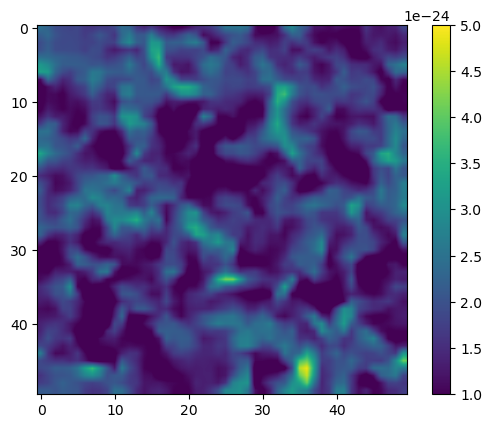

In [20]:
# We copy the array
B = rho_cgs
# Density map
plt.imshow(B.T, interpolation='bilinear',vmin=1.e-24,vmax=5.e-24)
plt.colorbar()
plt.show()

Now we can eliminate the values lower than the mean by doing the following:

In [21]:
A = B

# The line below replaces he values by NANs

A[A < np.mean(A)] = np.nan

Now let's plot A:

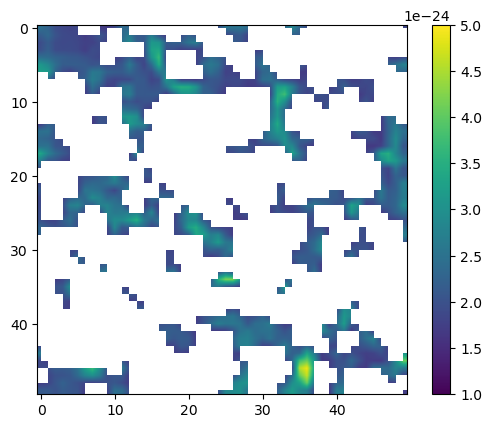

In [22]:
plt.imshow(A.T, interpolation='bilinear',vmin=1.e-24,vmax=5.e-24)
plt.colorbar()
plt.show()

## 5. Functions and loops:


To simplify the code, we can define a function that does all the above steps in one:

In [23]:
from astropy.io import ascii

In [24]:
def read_my_vtk(file_name):
    """Read Pluto's VTK simulation files and returns the variables in CGS units"""
    
    # Path to files
    input_directory="../../TURB_DRIVE_SUB/"
    file_name = file_name
    times_file = "vtk.out"
    
    # Normalisation values
    l0 = 3.086e+18                    # Length is 1pc
    v0 = 1.e+6                        # Velocity is 10km/s
    rho0 = 1.66e-24                   # In g/cm^3
    mu = 6.72E-01                     # Mean particle mass
    mm = 1.660E-24                    # 1 Atomic mass unit
    kb = 1.380E-16                    # in CGS units
    tem0 = (mu*(mm*(v0**2))/kb)       # in K
    bfi0 = 4*math.pi*(rho0*(v0**2))   # in Gauss

    # Standard VTK loading routines
    reader= vtk.vtkDataSetReader()
    reader.SetFileName(input_directory+file_name)
    reader.ReadAllVectorsOn()
    reader.ReadAllScalarsOn()
    reader.Update()

    # Get data using hearder information
    data = reader.GetOutput() 
    dens = data.GetCellData().GetArray("rho")
    vel1 = data.GetCellData().GetArray("vx1")
    vel2 = data.GetCellData().GetArray("vx2")
    bfi1 = data.GetCellData().GetArray("vx1")
    bfi2 = data.GetCellData().GetArray("vx2")
    
    # Get dimensions, needed to get 3D arrays, instead of 1D vectors
    dim = data.GetDimensions()
    vec = list(dim)
    vec = [i-1 for i in dim]
    
    # Copy data into numpy arrays
    rho = np.array(dens)
    vx1 = np.array(vel1)
    vx2 = np.array(vel2)
    Bx1 = np.array(bfi1)
    Bx2 = np.array(bfi2)
    
    # Reshape them into 3D arrays
    rho = rho.reshape(vec[0],vec[1],order='F')
    vx1 = vx1.reshape(vec[0],vec[1],order='F')
    vx2 = vx2.reshape(vec[0],vec[1],order='F')
    Bx1 = Bx1.reshape(vec[0],vec[1],order='F')
    Bx2 = Bx2.reshape(vec[0],vec[1],order='F')
    
    # In astrophysical units
    rho = rho*rho0       # Gas density in g/cm^3
    nrh = rho/(mu*mm)    # Gas number density in cm^-3
    vx1 = vx1*v0/1.e5    # X-velocity component in km/s
    vx2 = vx2*v0/1.e5    # Y-velocity component in km/s
    Bx1 = Bx1*bfi0       # X-Bfield component in G
    Bx2 = Bx2*bfi0       # Y-Bfield component in G
    
    # Times
    times = ascii.read(input_directory+times_file)
    times = np.array(times['col2'])*l0/v0 # 1D array containing the simulation time in seconds
    
    return times, rho, nrh, vx1, vx2, Bx1, Bx2
    # tr1 is a cloud material tracer

In [25]:
# Example for file 0000
times, dens, number_dens, velx, vely, Bfieldx, Bfieldy = read_my_vtk('data.0000.vtk')

## Loops:

Loops are useful because data are normally stored at different times, so we want to have time-dependent diagnostics.

We can use for, but be careful with nesting for loops because they will slow down the code!

In [26]:
for i in range(0,10,1):
    times, dens, number_dens, velx, vely, Bfieldx, Bfieldy = read_my_vtk('data.00{:02}.vtk'.format(i))

In [27]:
f = open('averages.txt', 'w')
f.write("Time  Mean_Vx\n")

for i in range(0,100,1):
    times, dens, number_dens, velx, vely, Bfieldx, Bfieldy = read_my_vtk('data.00{:02}.vtk'.format(i))
    
    average_velx = np.mean(velx)

    f.write("{:.5e} {:.5e}\n".format(times[i],average_velx))

f.close()

In [28]:
def readDatosTemperatura(filename):
    #Files opened will be closed automatically
    with open(filename)as file:
        all_data = []
        for lineas in file.readlines():
            all_data.append([value for value in lineas.split()])
            
    ##convert data string to float 
    data = []
    for i in range(1,6): 
        data.append(np.asarray(all_data[i], dtype=np.float64))       
    
    return   all_data,  data

Now, let's import the data we just wrote and plot it:

            Time   Mean_Vx
0   0.000000e+00  0.000000
1   6.008750e+11  0.003472
2   1.225490e+12  0.004908
3   1.843370e+12  0.007326
4   2.468550e+12 -0.070757
..           ...       ...
95  5.862150e+13 -0.396570
96  5.923750e+13 -0.339916
97  5.986380e+13 -0.372641
98  6.048030e+13 -0.477702
99  6.108640e+13 -0.600898

[100 rows x 2 columns]


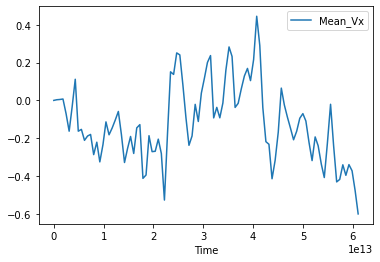

In [29]:
# From yesterday's lecture:

import pandas as pd

av_data = pd.read_csv('averages.txt', sep='\s+')

%matplotlib inline
print(av_data)
lines = av_data.plot.line(x='Time', y='Mean_Vx')